* nominal vs real growth - not necessary because 
* how much does it matter when they got into the market?
* fair game to use today's closing price when deciding to sell based on that day's closing price?
* candlestick plots?

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import plotnine as p9

In [2]:
dj = pd.read_csv("dow_jones_index.csv")

dj['Date'] = pd.to_datetime(dj['Date'])

dj.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


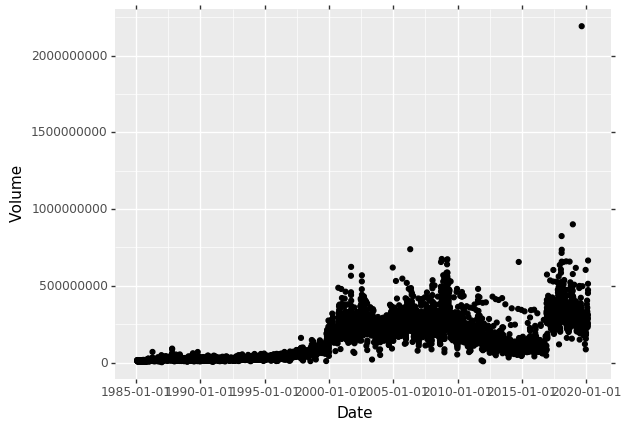

<ggplot: (7543616015)>

In [3]:
p9.ggplot(dj, p9.aes(x = "Date", y = "Volume")) + p9.geom_point()

In [4]:
date_start = "2000-01-01"

starting_amount = 5000

In [5]:
## person who invests and holds

holder = dj.loc[dj['Date'] >= date_start, ['Date', 'Close']].reset_index(drop = True)

start_shares = starting_amount/holder.loc[0, "Close"]
        
holder['money_value'] = holder['Close']*start_shares

holder['percent_gain'] = 100*holder['money_value']/starting_amount

holder.tail()

,Date,Close,money_value,percent_gain
5065,2020-02-21,28992.410156,12763.541812,255.270836
5066,2020-02-24,27960.800781,12309.388835,246.187777
5067,2020-02-25,27081.359375,11922.225881,238.444518
5068,2020-02-26,26957.589844,11867.737911,237.354758
5069,2020-02-27,25766.640625,11343.437583,226.868752


/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:74: UserWarning: geom_path: Removed 3 rows containing missing values.
  warn(msg.format(n1-n2))
/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


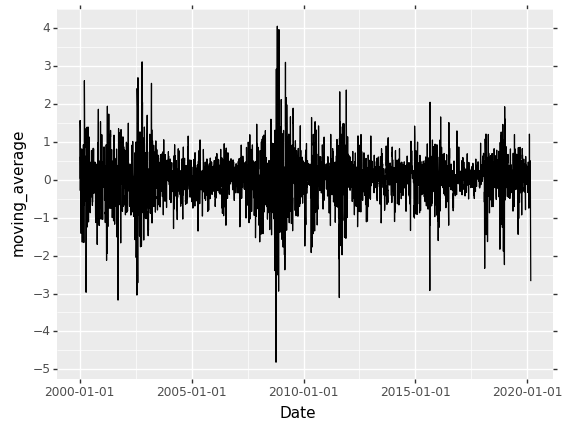

<ggplot: (-9223372029310563994)>

In [6]:
# moving average vs total movement over window 
# varying buy and sell percentages

measure = "moving_average"
window_days = 3
buy_perc_thresh = -3
sell_perc_thresh = 3

strategizer = dj.loc[dj['Date'] >= date_start, ['Date', 'Close']].reset_index(drop = True)

strategizer['last_day'] =  strategizer['Close'].shift(1)

strategizer['perc_change'] = 100*(strategizer['Close'] - strategizer['last_day'])/strategizer['last_day']

strategizer['moving_average'] = strategizer['perc_change'].rolling(window_days).mean()

p9.ggplot(strategizer, p9.aes(x = "Date", y = "moving_average")) + p9.geom_line() + p9.scale_y_continuous(breaks = range(-5, 6))



True

In [14]:
(row_df['transaction_type'] == "buy") and (money_type == "cash")

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [22]:
buying = strategizer.loc[strategizer['moving_average'] <= buy_perc_thresh]
buying['transaction_type'] = "buy"
selling = strategizer.loc[strategizer['moving_average'] >= sell_perc_thresh]
selling['transaction_type'] = "sell"

transactions = pd.concat([buying, selling]).sort_values('Date')

curr_value = starting_amount

money_type = "cash"

for date in transactions['Date']:
    
    row_df = transactions.loc[transactions['Date'] == date].reset_index()
    
    if (row_df['transaction_type'][0] == "buy") & (money_type == "cash"):
        start_shares = curr_value/row_df["Close"]
        holder['shares_value'] = holder['Close']*start_shares
        holder['percent_gain'] = 100*holder['shares_value']/starting_amount
    

/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [ ]:
strategizer['transaction_type'] = np.where(strategizer['moving_average'] <= buy_perc_thresh, "buy",
                                  np.where(strategizer['moving_average'] >= sell_perc_thresh, "sell", "hold"))

curr_value = starting_amount

money_type = "cash"

new_strategizer = pd.DataFrame()

for row in range(strategizer.shape[0]):
    
    print(row)
    
    row_df = strategizer.loc[row]
    
    if row_df['transaction_type'] == "hold":
    
        if money_type == "cash":
            row_df['money_value'] = curr_value

        elif money_type == "invested":
            # determine how much value is gained/lost by the change in the stock market that day
            row_df['money_value'] = (1 + row_df['perc_change']/100)*curr_value ## is this the correct formula
            curr_value = row_df['money_value']
        
    elif row_df['transaction_type'] == "buy":
        
        if money_type == "cash":
            money_type = "invested"
            row_df['money_value'] = curr_value
    
        elif money_type == "invested": # can't buy if invested
            row_df['transaction_type'] = "hold"
            ## do the action as if we were holding and invested
            row_df['money_value'] = (1 + row_df['perc_change']/100)*curr_value ## is this the correct formula
            curr_value = row_df['money_value'] 
        
    elif row_df['transaction_type'] == "sell":
        
        if money_type == "cash": # can't sell if holding cash
            row_df['transaction_type'] = "sell --> hold"
            row_df['money_value'] = curr_value  ## do the action as if we were holding cash
            
        elif money_type == "invested":
            money_type = "cash"
            row_df['money_value'] = curr_value 
        
    new_strategizer = new_strategizer.append(row_df)

In [74]:
new_strategizer.head()

,Close,Date,last_day,money_value,moving_average,perc_change,transaction_type
0,11357.509766,2000-01-03,NaN,5000.0,NaN,NaN,hold
1,10997.929688,2000-01-04,11357.509766,5000.0,NaN,-3.166012,hold
2,11122.650391,2000-01-05,10997.929688,5000.0,NaN,1.134038,hold
3,11253.259766,2000-01-06,11122.650391,5000.0,-0.285903,1.174265,hold
4,11522.559570,2000-01-07,11253.259766,5000.0,1.567128,2.393083,hold


/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


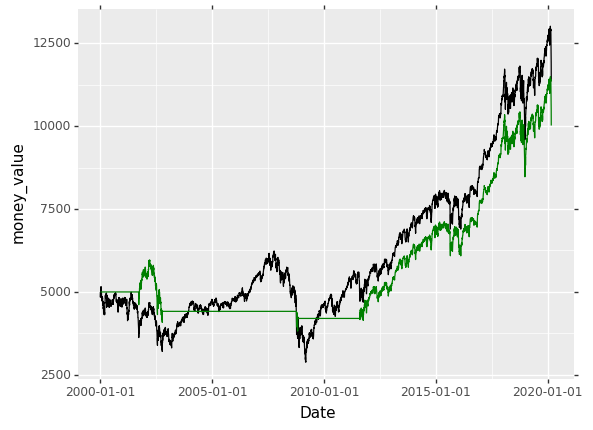

<ggplot: (7549515868)>

In [78]:
(p9.ggplot(p9.aes(x = "Date", y = "money_value")) +
p9.geom_line(data = holder) +
p9.geom_line(data = new_strategizer, color = "green"))